In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.models import Sequential, load_model
from keras.api.layers import Dense
import os
import importlib
import planar_manipulator
importlib.reload(planar_manipulator)
from planar_manipulator import PlanarManipulator

In [24]:
train_data = pd.read_csv('my_data_noised.csv')
X_data = train_data[['x2', 'y2']].to_numpy()
Y_data = train_data[['q1', 'q2']].to_numpy()


from sklearn.model_selection import train_test_split

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42
)

q1_lim = np.array([-np.pi, np.pi])
q2_lim = np.array([-np.pi, np.pi])

robot = PlanarManipulator(1.0, 1.0, q1_lim, q2_lim)

In [ ]:
def mdn_loss(y_true, y_pred):
    n_components = 2
    n_dims = 2

    # Split model outputs and process outputs
    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])

    # Normalized difference
    norm = (y_true_exp - mu) / sigma

    # Exponent term
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)

    # Normalizing coefficient
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))

    # Gaussian component density
    gauss = coeff * tf.exp(exponent)

    
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8

    loss = -tf.math.log(total_prob)
    return tf.reduce_mean(loss)


In [ ]:
def mdn_loss_with_joint_penalty(y_true, y_pred):
    n_components = 2
    n_dims = 2

    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])
    norm = (y_true_exp - mu) / sigma
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))
    gauss = coeff * tf.exp(exponent)
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8
    mdn_loss = -tf.math.log(total_prob)

    # --- Add joint limit penalty ---
    q1_min, q1_max = -np.pi/2, np.pi/2
    q2_min, q2_max = -np.pi/3, np.pi/3

    q1 = mu[:, :, 0]
    q2 = mu[:, :, 1]

    q1_violation = tf.maximum(0.0, q1 - q1_max) + tf.maximum(0.0, q1_min - q1)
    q2_violation = tf.maximum(0.0, q2 - q2_max) + tf.maximum(0.0, q2_min - q2)

    joint_penalty = tf.reduce_sum(q1_violation + q2_violation, axis=1)

    return tf.reduce_mean(mdn_loss + 10.0 * joint_penalty)  # Adjust weight if needed


In [ ]:
def build_mdn_model():
    model = Sequential([
        Dense(50, activation='relu', input_shape=(2,)),
        Dense(50, activation='relu'),
        Dense(50, activation='relu'),

        Dense(10)
    ])
    return model

In [ ]:
model_path = 'models/my_mdn2_1_model_50_50_50.keras'

if os.path.exists(model_path):
    model = load_model(model_path, custom_objects={'mdn_loss': mdn_loss})
else:
    model = build_mdn_model()
    model.compile(optimizer='adam', loss=mdn_loss)
    model.summary()

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, Y_val)
    )
    model.save(model_path)


C:\Users\yanto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,760 (22.50 KB)

 Trainable params: 5,760 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6173 - val_loss: 0.1011
Epoch 2/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -0.0421 - val_loss: -1.1671
Epoch 3/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -1.3746 - val_loss: -1.8317
Epoch 4/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -1.7635 - val_loss: -1.7600
Epoch 5/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -1.9255 - val_loss: -2.1040
Epoch 6/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -1.9965 - val_loss: -2.0687
Epoch 7/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -2.0476 - val_loss: -1.6659
Epoch 8/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -2.0319 - val_loss: -1.9118
Epoch 9/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: -2.0426 - val_loss: -2.1915
Epoch 10/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -2.0642 - val_loss: -2.1264
Epoch 11/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -2.0564 - val_loss: -2.1451

In [28]:
test_data = pd.read_csv('my_data.csv')
X_data = test_data[['x2', 'y2']].to_numpy()
Y_data = test_data[['q1', 'q2']].to_numpy()

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=42
)
pred = model.predict(X_test)

def decode_mdn_output(pred):
    n_components = 2
    n_dims = 2

    pi_logits = pred[:, :n_components]
    pi = tf.nn.softmax(pi_logits).numpy()

    mu = pred[:, n_components:n_components + n_components * n_dims]
    mu = mu.reshape(-1, n_components, n_dims)

    sigma = pred[:, n_components + n_components * n_dims:]
    sigma = np.exp(sigma).reshape(-1, n_components, n_dims)

    return pi, mu, sigma

pi, mu, sigma = decode_mdn_output(pred)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [29]:
for i in range(6):
    print(f"Sample {i+1}:")
    print(f"  Input Cartesian (x2, y2): {X_test[i]}")
    print(f"  True joint angles (q1, q2): {Y_test[i]}")
    print(f"  Mixing probabilities: {pi[i]}")
    print(f"  Solution 1 mean (q1, q2): {mu[i, 0]} sigma: { sigma[i, 0]}")
    print(f"  Solution 2 mean (q1, q2): {mu[i, 1]} sigma: {sigma[i, 1]}")
    print()

Sample 1:
  Input Cartesian (x2, y2): [0.10650741 1.99156165]
  True joint angles (q1, q2): [1.44256806 0.14959965]
  Mixing probabilities: [0.49760187 0.5023982 ]
  Solution 1 mean (q1, q2): [ 1.5212431  -0.00725996] sigma: [0.04191417 0.08626003]
  Solution 2 mean (q1, q2): [1.3847153  0.27436215] sigma: [0.0459852  0.09036323]

Sample 2:
  Input Cartesian (x2, y2): [ 1.49270611 -1.32680855]
  True joint angles (q1, q2): [-0.67319843 -0.10685689]
  Mixing probabilities: [0.5004656  0.49953443]
  Solution 1 mean (q1, q2): [-0.5885706  -0.24642076] sigma: [0.07074798 0.1395567 ]
  Solution 2 mean (q1, q2): [-0.8430928   0.24249679] sigma: [0.06483757 0.12854329]

Sample 3:
  Input Cartesian (x2, y2): [ 1.46200422 -1.35654167]
  True joint angles (q1, q2): [-0.67319843 -0.14959965]
  Mixing probabilities: [0.4984207 0.5015793]
  Solution 1 mean (q1, q2): [-0.60408735 -0.25851706] sigma: [0.07212275 0.14198904]
  Solution 2 mean (q1, q2): [-0.8706601   0.25443348] sigma: [0.06604922 0.13

In [30]:
def count_out_of_bounds(q, q1_lim, q2_lim):
    q = np.atleast_2d(q)
    q1, q2 = q[:, 0], q[:, 1]
    valid_q1 = (q1_lim[0] <= q1) & (q1 <= q1_lim[1])
    valid_q2 = (q2_lim[0] <= q2) & (q2 <= q2_lim[1])
    valid_mask = valid_q1 & valid_q2

    total = len(valid_mask)
    invalid = np.sum(~valid_mask)
    print(f"Total samples: {total}")
    print(f"Out of bounds: {invalid} ({100 * invalid / total:.2f}%)")
    return None

count_out_of_bounds(mu[:,0,:], q1_lim=[-np.pi/2, np.pi/2], q2_lim=[-np.pi/3, np.pi/3])
count_out_of_bounds(mu[:,1,:], q1_lim=[-np.pi/2, np.pi/2], q2_lim=[-np.pi/3, np.pi/3])

Total samples: 375
Out of bounds: 2 (0.53%)
Total samples: 375
Out of bounds: 17 (4.53%)


In [31]:
def evaluate_accuracy(robot, X_test, mu):
    _, ee_pred_0 = robot.forward_kinematics(mu[:, 0, :])
    _, ee_pred_1 = robot.forward_kinematics(mu[:, 1, :])

    errors_0 = np.linalg.norm(X_test - ee_pred_0, axis=1)
    errors_1 = np.linalg.norm(X_test - ee_pred_1, axis=1)

    avg_err0 = np.mean(errors_0)
    avg_err1 = np.mean(errors_1)

    return avg_err0, avg_err1

error_0, error_1 = evaluate_accuracy(robot, X_test, mu)
print(f"Average End-Effector Error (Mode 0): {error_0:.6f}")
print(f"Average End-Effector Error (Mode 1): {error_1:.6f}")

Average End-Effector Error (Mode 0): 0.027132
Average End-Effector Error (Mode 1): 0.020960


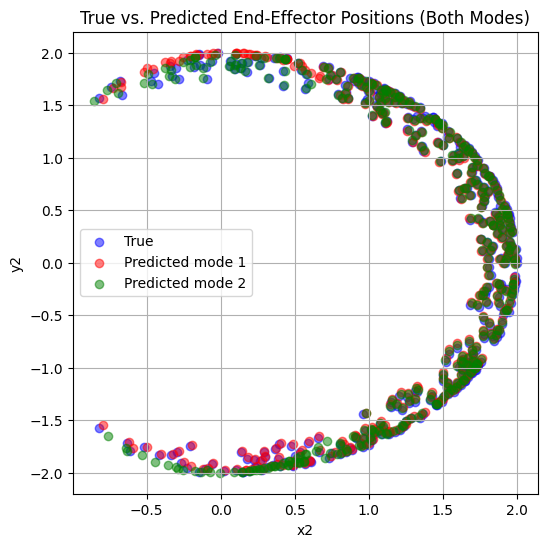

In [32]:
# Plot solutions in Cartesian space
plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0], X_test[:,1], color='blue', alpha=0.5, label='True')

# Plot both predicted modes for all test samples
_, x2y2_mode1= robot.forward_kinematics(mu[:,0,:])
_, x2y2_mode2 = robot.forward_kinematics(mu[:,1,:])
plt.scatter(x2y2_mode1[:,0], x2y2_mode1[:,1], color='red', alpha=0.5, label='Predicted mode 1')
plt.scatter(x2y2_mode2[:,0], x2y2_mode2[:,1], color='green', alpha=0.5, label='Predicted mode 2')

plt.legend()
plt.xlabel('x2')
plt.ylabel('y2')
plt.title('True vs. Predicted End-Effector Positions (Both Modes)')
plt.grid()
plt.show()

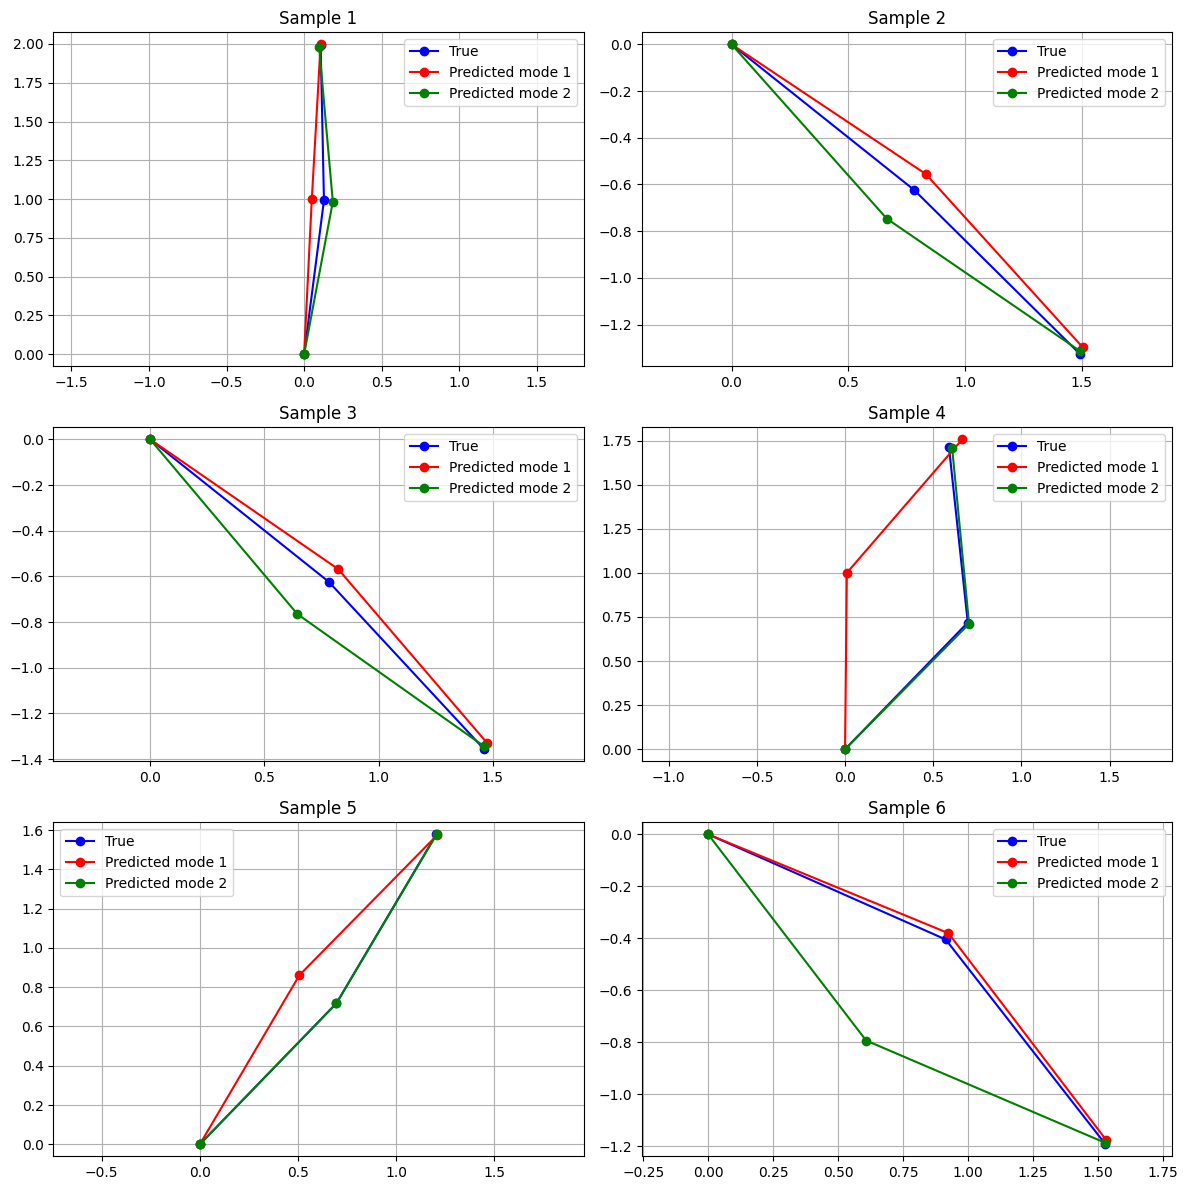

In [33]:
num_samples = 6
plt.figure(figsize=(12, 12))

for i in range(num_samples):
    plt.subplot(3, 2, i+1)

    # Ground-truth (blue)
    robot.plot(Y_test[i, 0], Y_test[i, 1], color='blue', label='True')

    # Predicted mode 1 (red)
    robot.plot(mu[i, 0, 0], mu[i, 0, 1], color='red', label='Predicted mode 1')

    # Predicted mode 2 (green)
    robot.plot(mu[i, 1, 0], mu[i, 1, 1], color='green', label='Predicted mode 2')

    plt.title(f'Sample {i+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()